In [1]:
import cv2
import os
import json
import gc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from PIL import Image
import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2B0

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout

In [2]:
metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"
input_shape=(224,224)
batch_size=16

In [3]:
def open_image(image_path):
        # Load the image using Pillow
    pil_img = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)
    img_array = np.array(pil_img)
    return img_array

def show_image(img_array):
    if(img_array.shape[2]== 1):
        plt.imshow(img_array.astype('uint8'), cmap='gray')
    else:
        plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [4]:
def get_data_labels_and_metadata(dataset):
    """
    Extracts data and labels from a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to extract data and labels from.

    Returns:
        Tuple of (data, labels), where:
        - data is a NumPy array of features.
        - labels is a NumPy array of labels.
    """
    data = []
    labels = []
    metadatas=[]
    dataset = dataset.unbatch()

    for features, label, metadata in dataset:
        data.append(features.numpy())
        labels.append(label.numpy())
        metadatas.append(metadata.numpy())

    # Convert lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    metadata = np.array(metadatas)

    return data, labels, metadata


In [5]:
def create_dataset(data, labels, metadata, batch_size=batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from images and labels.

    Args:
        data (list or np.array): List or array of image data.
        labels (list or np.array): Corresponding labels.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: A TensorFlow dataset.
    """

    dataset = tf.data.Dataset.from_tensor_slices((data, labels, metadata))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# One hot encoding
class_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["TC", "TS"]),
        values=tf.constant([0, 1])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode(data, label, metadata):
    num_classes = 2  # Adjust this to the actual number of classes
    # Map string labels to integers

    label = class_mapping.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label, metadata

In [6]:
def load_metadata_json(metadata_path):
    """
    Load metadata from a JSON file.
    Args:
        metadata_path (str): Path to the metadata file (JSON format).
    Returns:
        list: A list of dictionaries with metadata.
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata


def match_metadata_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages']

    for entry in metadata_merged:
        # Extract filename, label, and metadata features
        filename = entry['File']
        # participant_id = entry['ParticipantID']
        # age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        # gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # if(image_dir.find("Unseen")):
        #     if(math.isnan(cars_score)):
        #         label= 

        # # Determine the label
        # if(cars_score==0):
        #     label = "TC"
        # else: 
        #     label = "TS"

        subdir=''
        # Determine the image path
        if "TC" in filename:
            subdir = 'TCImages'
            label='TC'
        elif "TS" in filename:
            subdir = 'TSImages'
            label='TS'
            
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists

        if os.path.exists(image_path):

            img_array = open_image(image_path)
            data.append(img_array)

            # Collect label and metadata features
            labels.append(label)
            metadata_features.append(
                #'CARS':
                cars_score
                # 'ParticipantID': participant_id,
                # 'Age': age,
                # 'Gender': gender,
            )
        else:
            print(f"Warning: Image {filename} not found! {image_path}")

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    # metadata_features_array = np.array([

    #         feature['CARS']
    #         # float(feature['ParticipantID']),
    #         # feature['Age'],
    #         # hash(feature['Gender']) if feature['Gender'] is not None else 0

    #     #for feature in metadata_features
    # ]).astype('float32')

    metadata_features_array = np.array(metadata_features)

    metadata_features_array = np.nan_to_num(metadata_features_array, nan=0.0)

    return data, labels, metadata_features_array


In [7]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image


def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    #laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    laplacian_img =cv2.threshold(img_array, 4, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        #grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
        resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)
        resized_img = np.expand_dims(resized_img, axis=-1)
    else:
      grayscale_img = laplacian_img
      resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)
      
    return resized_img

def preprocess_dataset(concat_data, concat_labels, target_size, color):
    """
    Processes a MapDataset and prepares the dataset.
    Assumes the dataset yields tuples of (image, label).
    """
    data = []
    labels = []

    for img_array, label in zip(concat_data, concat_labels):
        processed_image = preprocess_image(img_array, color, target_size)
        data.append(processed_image)
        labels.append(label)

    # Add a channel dimension for grayscale images (required for CNN input)
    # if color==False:
    #     data = np.expand_dims(data, axis=-1)

    data = np.array(data)
    labels = np.array(labels)

    #processed_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return data, labels

def save_dataset(dataset, dataset_name):
    # Initialize lists to store dataset elements (features, labels)
    features_list = []
    labels_list = []
    metadata_list = []

    # Iterate through the dataset and collect the elements
    for features, labels, metadata in dataset:
        features_list.append(features.numpy())  # Convert tensors to NumPy
        labels_list.append(labels.numpy())
        metadata_list.append(metadata.numpy())

    # Save as .npy files
    np.save(f"{dataset_name}_features.npy", np.array(features_list))
    np.save(f"{dataset_name}_labels.npy", np.array(labels_list))
    np.save(f"{dataset_name}_metadata.npy", np.array(metadata_list))
    print(f"Dataset saved as {dataset_name}_features.npy and {dataset_name}_labels.npy")

def load_dataset(dataset_name):
    # Load the saved NumPy arrays
    features = np.load(f"{dataset_name}_features.npy",allow_pickle=True)
    labels = np.load(f"{dataset_name}_labels.npy",allow_pickle=True)
    metadata = np.load(f"{dataset_name}_metadata.npy",allow_pickle=True)

    # Convert them back to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features)
    labels_tensor = tf.convert_to_tensor(labels)
    metadata_tensor = tf.convert_to_tensor(metadata)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor, metadata_tensor))
    return dataset

In [8]:
# Load the metadata
metadata_list = load_metadata_json(metadata_path)

# Preprocess data and metadata
data, labels, metadata_features = match_metadata_with_images_json(image_dir, metadata_list)

In [9]:
data, labels = preprocess_dataset(data, labels, target_size=input_shape, color=True)

In [10]:
# Define Data Augmentation Pipeline
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.5, interpolation="nearest"),
#     layers.RandomZoom(0.2),
#     layers.RandomTranslation(0.2,0.2)
#     #layers.RandomBrightness(0.1),
# ])
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.Rotate(limit=30, interpolation=1, border_mode=0, p=0.5),  
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.5),  
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),  
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  
    A.Normalize(mean=[0.5], std=[0.5]),  # For grayscale masks, use mean & std of [0.5]
    ToTensorV2()
])

def albumentations_augment(image):
    """
    Applies Albumentations transformations to a single image.
    Expects image as a NumPy array.
    """
    augmented = albumentations_augmentation(image=image)
    return augmented["image"]

def augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=32):
    """
    Augment images multiple times using Albumentations while keeping metadata aligned.

    Args:
        data (tf.Tensor): Input tensor of images.
        labels (tf.Tensor): Corresponding labels.
        metadata_features (np.array or tf.Tensor): Metadata for each image.
        augmentations (int): Number of augmentations to apply.
        batch_size (int): Number of images to process per batch.

    Returns:
        augmented_images (tf.Tensor): Augmented images.
        augmented_labels (tf.Tensor): Augmented labels.
        augmented_metadata (tf.Tensor): Augmented metadata.
    """
    augmented_images = []
    augmented_labels = []
    augmented_metadata = []

    for i in range(0, data.shape[0], batch_size):
        batch_data = data[i:i+batch_size]  # Convert to NumPy
        batch_labels = labels[i:i+batch_size]
        batch_metadata = metadata_features[i:i+batch_size]

        for _ in range(augmentations):
            batch_augmented = np.array([albumentations_augment(img) for img in batch_data])

            batch_augmented = ((batch_augmented + 1) * 127.5)

            # Convert back to TensorFlow tensor
            augmented_images.append(tf.convert_to_tensor(batch_augmented, dtype=tf.float16))
            augmented_labels.append(batch_labels)
            augmented_metadata.append(batch_metadata)

    # Concatenate augmented batches
    augmented_images = tf.concat(augmented_images, axis=0)
    augmented_labels = tf.concat(augmented_labels, axis=0)
    augmented_metadata = tf.concat(augmented_metadata, axis=0)

    return augmented_images, augmented_labels, augmented_metadata

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Alex\AppData\Local\Temp\ipykernel_12152\3419089690.py:17: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
C:\Users\Alex\AppData\Local\Temp\ipykernel_12152\3419089690.py:19: UserWarning: Argument 'max_holes' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
C:\Users

In [11]:
def plot_training_history(history, model_name="Model"):
    """
    Plots training and validation accuracy and loss for a given training history side by side.
    
    Args:
        history: Keras training history object.
        model_name: Name of the model (string) for labeling purposes.
    """
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot training and validation accuracy
    axes[0].plot(epochs, accuracy, 'b', label='Training Accuracy')
    axes[0].plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    axes[0].set_title(f'Training and Validation Accuracy ({model_name})')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid()
    
    # Plot training and validation loss
    axes[1].plot(epochs, loss, 'b', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[1].set_title(f'Training and Validation Loss ({model_name})')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid()
    
    # Show the combined plots
    plt.tight_layout()
    plt.show()

In [12]:
with tf.device('/CPU:0'):
    augmented_data, augmented_labels, augmented_metadata = augment_multiple_times(data, labels, metadata_features, augmentations=17, batch_size=batch_size)

In [13]:
with tf.device('/CPU:0'):
    augmented_data = tf.transpose(augmented_data, [0, 2, 3, 1])

In [14]:
combined_data = np.concatenate((data, augmented_data), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)
combined_metadata = np.concatenate((metadata_features, augmented_metadata), axis=0)

In [15]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Example Tensor of string labels
tensor_data = tf.constant(combined_labels, dtype=tf.string)

# Convert the tensor to a list of strings
strings = tensor_data.numpy().astype(str)

# Reshape the data to match the expected input shape for OneHotEncoder
strings_reshaped = np.array(strings).reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the data
combined_labels = encoder.fit_transform(strings_reshaped)


In [16]:
gc.collect()

20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.0].


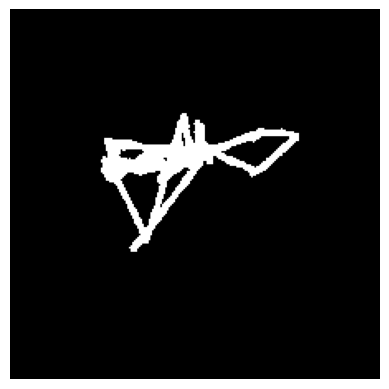

In [17]:
with tf.device('/CPU:0'):
    show_image(combined_data[1000].astype(np.float32))

In [18]:
from sklearn.model_selection import train_test_split

with tf.device('/CPU:0'):
    train_data, test_data, train_labels, test_labels, train_metadata, test_metadata = train_test_split(
        combined_data, 
        combined_labels, 
        combined_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,

    )

    train_data, validation_data, train_labels, validation_labels, train_metadata, validation_metadata = train_test_split(
        train_data, 
        train_labels, 
        train_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,  # Optional: For reproducibility
    )

In [19]:
max_cars_score = 60
train_metadata = tf.cast(train_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]

train_metadata = tf.constant(1, dtype=float) + train_metadata
# for i in range(len(train_metadata)):
#     train_metadata[i] = 1.0 + train_metadata[i]  # Rescale to [1, 2]

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def categorical_focal_loss(gamma=2, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification.
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- Weighting factor for class imbalance.
        gamma -- Focusing parameter for modulating factor (1-p).
    """
    # @tf.function
    def focal_loss(y_true, y_pred, sample_weight=None):  # Add sample_weight as an argument

        y_true = tf.cast(y_true, tf.float32)

        # Define epsilon to avoid NaN in backpropagation
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate the cross entropy (log loss)
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate weight, which combines alpha and the focusing factor (1-p)^gamma
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute focal loss
        loss = weight * cross_entropy

        # Sum the losses in the batch
        loss = K.sum(loss, axis=1)

        # If sample_weight is provided, multiply it by the loss
        if sample_weight is not None:
            loss = loss * sample_weight  # Apply sample weights

        return loss
    
    return focal_loss

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)

<h1> PCA </h1>

In [26]:
from sklearn.preprocessing import StandardScaler

def apply_pca(data, labels, n_components=50):
    """
    Apply PCA to reduce the dimensionality of flattened image data.
    Args:
        data (np.array): Flattened image data of shape (n_samples, height * width).
        labels (np.array): Corresponding labels of shape (n_samples,).
        n_components (int): Number of principal components to keep.
    Returns:
        np.array, np.array, PCA: Transformed data, labels, and PCA model.
    """
    data = data.reshape(data.shape[0], -1)
    # Ensure the data is 2D (flattened images)
    # if data.ndim == 3 and data.shape[-1] == 1:  # Handle (n_samples, height, 1)
    #     data = np.squeeze(data, axis=-1)

    if data.ndim != 2:
        raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {data.shape}.")

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Initialize PCA and fit it on the flattened data
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance by Principal Components")
    plt.grid()
    plt.show()

    return data_pca, labels, pca, scaler


In [27]:
train_data = train_data.reshape(train_data.shape[0], -1)
# Ensure the data is 2D (flattened images)
# if data.ndim == 3 and data.shape[-1] == 1:  # Handle (n_samples, height, 1)
#     data = np.squeeze(data, axis=-1)

if train_data.ndim != 2:
    raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {train_data.shape}.")

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

In [28]:
gc.collect()

0

In [29]:
from sklearn.decomposition import IncrementalPCA

train_data_scaled = train_data_scaled.astype(np.float32)
pca = IncrementalPCA(n_components=500, batch_size=512)
train_data_pca = pca.fit_transform(train_data_scaled)

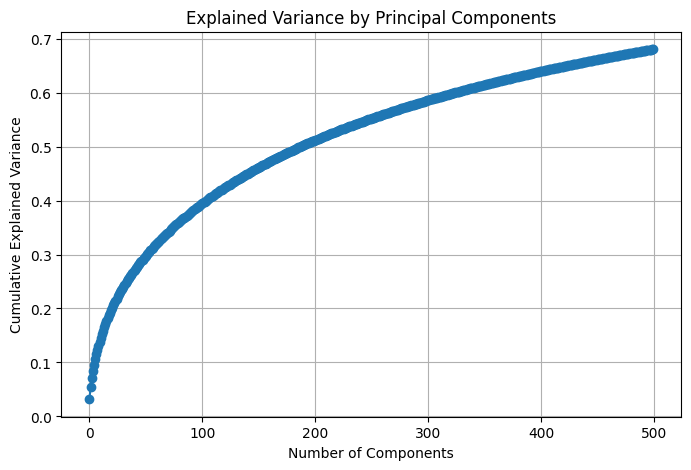

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid()
plt.show()

In [33]:
validation_data = validation_data.reshape(validation_data.shape[0], -1)

if validation_data.ndim != 2:
    raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {validation_data.shape}.")

validation_data_scaled = scaler.transform(validation_data)

validation_data_pca = pca.transform(validation_data_scaled)

In [ ]:

n_components=500

def create_model_pca(input_shape, n_classes):
    model = Sequential([
       Dense(64, activation='relu', input_shape=(n_components,), kernel_regularizer=l2(0.02)),
       BatchNormalization(),
        Dropout(0.4),  # Helps prevent overfitting
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
       Dropout(0.4),
        Dense(2, activation='softmax')  # Assuming 2 classes
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=categorical_focal_loss(),
                  #loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize model
model_pca = create_model_pca(input_shape=(n_components,), n_classes=2)

# Display model summary
model_pca.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                32064     
                                                                 
 batch_normalization_18 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_19 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 32)               

In [68]:
history_pca = model_pca.fit(train_data_pca, train_labels, batch_size=batch_size, epochs=50,
                            callbacks=[early_stopping, reduce_lr],
                            validation_data=(validation_data_pca, validation_labels),
                            sample_weight=train_metadata,
                            )

Epoch 1/50
394/394 [==============================] - 4s 9ms/step - loss: 2.6185 - accuracy: 0.4933 - val_loss: 2.2357 - val_accuracy: 0.5178 - lr: 1.0000e-04
Epoch 2/50
394/394 [==============================] - 1s 3ms/step - loss: 2.0955 - accuracy: 0.5449 - val_loss: 1.7960 - val_accuracy: 0.6231 - lr: 1.0000e-04
Epoch 3/50
394/394 [==============================] - 1s 3ms/step - loss: 1.6719 - accuracy: 0.5830 - val_loss: 1.4282 - val_accuracy: 0.6796 - lr: 1.0000e-04
Epoch 4/50
394/394 [==============================] - 1s 2ms/step - loss: 1.3242 - accuracy: 0.5957 - val_loss: 1.1237 - val_accuracy: 0.7011 - lr: 1.0000e-04
Epoch 5/50
394/394 [==============================] - 1s 2ms/step - loss: 1.0423 - accuracy: 0.6175 - val_loss: 0.8782 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 6/50
394/394 [==============================] - 1s 2ms/step - loss: 0.8137 - accuracy: 0.6273 - val_loss: 0.6829 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 7/50
394/394 [==========================

In [32]:
test_data = test_data.reshape(test_data.shape[0], -1)

test_data_scaled = scaler.transform(test_data)
test_data_pca = pca.transform(test_data_scaled)

In [69]:
with tf.device('/CPU:0'):
    y_pred=model_pca.predict(test_data_pca)

62/62 [==============================] - 0s 1ms/step


In [73]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
print(cm)

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

print(f"Recall: {recall_score(y_true_labels, y_pred_labels):.4f}")
print(f"Precision: {precision_score(y_true_labels, y_pred_labels):.4f}")
print(f"F1 score: {f1_score(y_true_labels, y_pred_labels):.4f}")

Accuracy: 0.7299
[[963 297]
 [235 475]]
Recall: 0.6153
Precision: 0.6690
F1 score: 0.6410


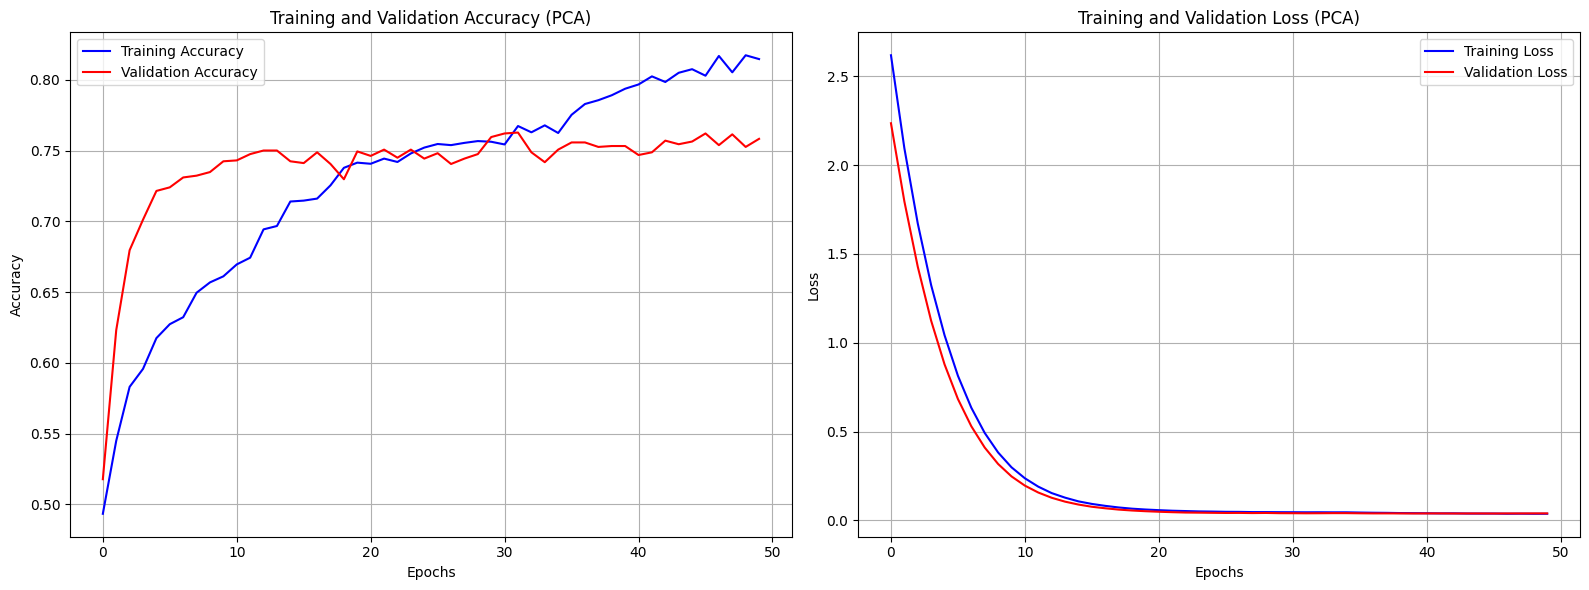

In [74]:
plot_training_history(history_pca, "PCA")

<h1> CNN </h1>

In [26]:
def feature_extractor_cnn(input_shape):
    model = Sequential()

    # Level 1: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(rate=0.5, seed=42))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 2: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(rate=0.5))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 3: Convolution + ReLU + MaxPooling
    # model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    # #model.add(Dropout(rate=0.5, seed=42))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    # Level 4: Convolution + ReLU + MaxPooling
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Dropout(rate=0.3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    return model

In [21]:
cnn_feature_extractor = feature_extractor_cnn((224,224,3))

In [31]:
def create_model_cnn():
    model = Sequential([
        cnn_feature_extractor,
        #Dense(512, activation='relu'),
        #Dense(254, activation='relu'),
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(rate=0.3),
        Dense(64, activation='relu'),  # Fully connected layer
        Dropout(rate=0.3),
        Dense(2, activation='softmax')  # Output layer for classification (e.g., 10 classes)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  #loss=categorical_focal_loss(),
              loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])
    return model

In [32]:
model_cnn = create_model_cnn()

# 3. Compile the model
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100352)            116576    
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,970,146
Trainable params: 12,970,146


In [33]:
gc.collect()

377

In [34]:
history_cnn = model_cnn.fit(train_data, train_labels, batch_size=batch_size, epochs=10,
                            callbacks=[early_stopping, reduce_lr],
                            validation_data=(validation_data, validation_labels),
                            sample_weight=train_metadata,
                            )

Epoch 1/10
394/394 [==============================] - 273s 692ms/step - loss: 0.8247 - accuracy: 0.6806 - val_loss: 0.5742 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 2/10
394/394 [==============================] - 272s 690ms/step - loss: 0.6741 - accuracy: 0.7183 - val_loss: 0.5687 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 3/10
394/394 [==============================] - 285s 723ms/step - loss: 0.6615 - accuracy: 0.7329 - val_loss: 0.5585 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 4/10
394/394 [==============================] - 274s 696ms/step - loss: 0.6278 - accuracy: 0.7529 - val_loss: 0.5418 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 5/10
394/394 [==============================] - 270s 685ms/step - loss: 0.6203 - accuracy: 0.7549 - val_loss: 0.5060 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 6/10
394/394 [==============================] - 269s 684ms/step - loss: 0.5899 - accuracy: 0.7668 - val_loss: 0.5310 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 7/10
394/394 [==========================

In [35]:
with tf.device('/CPU:0'):
    y_pred_cnn=model_cnn.predict(test_data)

62/62 [==============================] - 15s 207ms/step


In [36]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_cnn, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
print(cm)

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

print(f"Recall: {recall_score(y_true_labels, y_pred_labels):.4f}")
print(f"Precision: {precision_score(y_true_labels, y_pred_labels):.4f}")
print(f"F1 score: {f1_score(y_true_labels, y_pred_labels):.4f}")

Accuracy: 0.7452
[[1009  313]
 [ 189  459]]
Recall: 0.5946
Precision: 0.7083
F1 score: 0.6465


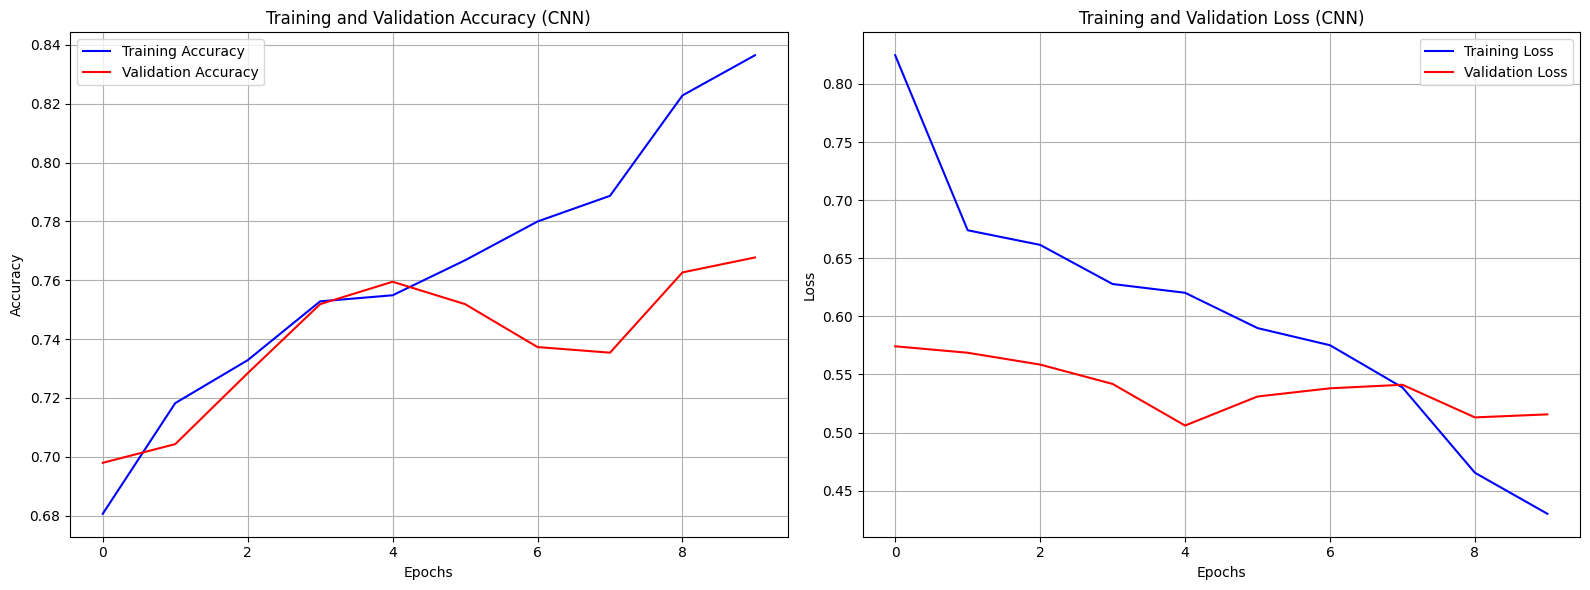

In [37]:
plot_training_history(history_cnn, "CNN")

<h1> Voting ensemble </h1>

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report


In [36]:
estimator = []
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42,criterion="log_loss" , max_depth=10,
                                                               max_features='log2',# class_weight=class_weight_dict,
                                                                n_estimators=2000, min_samples_leaf=10) ))
estimator.append(('RandomForest', RandomForestClassifier(random_state=42, n_estimators=500#,min_samples_leaf= 2, min_samples_split= 50
                                                         ) ))
estimator.append(('BaggingClassifier', BaggingClassifier(n_estimators=10, random_state=42)))
estimator.append(('XGBClassifier', XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss",
    use_label_encoder=False)))

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


# Create the Voting Classifier
VC_hard = VotingClassifier(estimators=estimator, voting='soft')


# Fit the model
#VC_hard.fit(X_train, train_labels_1d)  # Use 1D labels directly


In [25]:
if train_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = train_data.reshape(train_data.shape[0], -1)

if test_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_test = test_data.reshape(test_data.shape[0], -1)

In [25]:
y_train = np.argmax(train_labels, axis=1)
y_test = np.argmax(test_labels, axis=1)

In [ ]:
# from sklearn.metrics import mean_squared_error, log_loss

# ada= GradientBoostingClassifier(loss='log_loss',
#                                 min_samples_leaf=5, n_estimators=500,
#                                 learning_rate=0.01, criterion='squared_error').fit(X_train, y_train, train_metadata)

# errors = [ log_loss(y_test, preds) for preds in ada.staged_predict(X_test)]

# optimal_num_estimators = np.argmin(errors) + 1

In [ ]:
from sklearn.metrics import accuracy_score

for name, model in VC_hard.estimators:
    model.fit(train_data_pca, y_train,
              sample_weight=train_metadata)
    y_pred = model.predict(test_data_pca)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

ExtraTreesClassifier Accuracy: 0.7243654822335025
RandomForest Accuracy: 0.7558375634517767
BaggingClassifier Accuracy: 0.7517766497461928


c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\xgboost\core.py:158: UserWarning: [14:00:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier Accuracy: 0.7619289340101523


In [44]:
VC_hard.fit(train_data_pca, y_train,
              sample_weight=train_metadata)

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('ExtraTreesClassifier',
                              ExtraTreesClassifier(criterion='log_loss',
                                                   max_depth=10,
                                                   max_features='log2',
                                                   min_samples_leaf=10,
                                                   n_estimators=2000,
                                                   random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42)),
                             ('BaggingClassifier',
                              BaggingClassifier(random_state=42)),
                             ('XGBClassifier',
                              XGBClassifier(base...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [45]:
y_pred_vc = VC_hard.predict(test_data_pca)

In [47]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = y_pred_vc  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
print(cm)

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

print(f"Recall: {recall_score(y_true_labels, y_pred_labels):.4f}")
print(f"Precision: {precision_score(y_true_labels, y_pred_labels):.4f}")
print(f"F1 score: {f1_score(y_true_labels, y_pred_labels):.4f}")

Accuracy: 0.7706
[[1071  325]
 [ 127  447]]
Recall: 0.5790
Precision: 0.7787
F1 score: 0.6642
